# Dressed Matrix-model T-brane

The purpose of this notebook is to carry out some of the calculations of sections 2 and 3 of [1703.06106](https://arxiv.org/abs/1703.06106).

This notebook depends on SymPy.

We will start by importing SymPy and constructing a the commutator, and also the anti-commutator.

In [1]:
from sympy import *
init_printing(use_unicode = True)

def com(x,y):
    return x*y - y*x

def acom(x,y):
    return x*y + y*x

Will will start from around Eq. (2.2), in which we have the Hitchin system written in terms of constant fields. We have a number of non-commuting fields, $\Phi$ and $A_w$, and altough these should be thought of as matrices, SymPy lacks some functionallity for `MatrixSymbol`s (see [SymPy PR#11774](https://github.com/sympy/sympy/pull/11774) and [SymPy Issue#10360](https://github.com/sympy/sympy/issues/10360)), so we will simply use these as non-commutative constants.

In [2]:
Aw, Awbar, Phi = symbols('A_w,A_{\\bar{w}}, Phi', commutative=False)

The first calculation, of sorts is to rewrite Eq. (2.2) to Eq. (2.4) using Eq. (2.3), so we need to introduce some more matrices (Hermitian) and substitution rules.

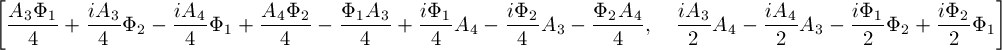

In [3]:
A3, A4, Phi1, Phi2 = symbols('A_3, A_4, Phi_1, Phi_2', commutative=False, hermitian=True)

from sympy.physics.quantum import Dagger # Hermitian Conjugate

# Eq. (2.3)
cplx2real = [(Aw, -(A3+I*A4)/2),
            (Awbar, (A3-I*A4)/2),
            (Phi, (Phi1 + I*Phi2)/2),
            (Dagger(Phi), (Phi1 - I*Phi2)/2)]

# Eq. (2.2)

Eq22 = [
    com(Awbar, Phi), com(Aw, Awbar) + com(Phi,Dagger(Phi))
]

# Eq. (2.4)

Eq240 = [ e.subs(cplx2real).expand() for e in Eq22]

Eq240

We now need to manipulate `Eq240` slightly to extract the correct expressions.

In [4]:

Eq24 = []
Eq24.append(((Eq240[0]+Dagger(Eq240[0]))*2*-I).expand())
Eq24.append(((Eq240[0]-Dagger(Eq240[0]))*-2).expand())
Eq24.append(((Eq240[1])*2*I).expand())
Eq24

T-duality is quite trivial here simply exchange $A_i$ for $\Phi_i$, so to derive Eq. (2.5) simply

In [5]:
Phi3, Phi4 = symbols('Phi_3, Phi_4', commutative=False, hermitian=True)

Tdual = [(A3, Phi3), (A4, Phi4)]

Eq25 = [ e.subs(Tdual) for e in Eq24]
Eq25

That concludes the small calculation in Section 2. Eq. (2.6) is left as an exercise. We now move to Section 3, and we will start by introducing the matrices in Eq. (3.4) and make them satisfy Eq. (3.5)

In [6]:
Ds = D1, D2, D3, D4 = symbols('D_{(1:5)}', commutative=False, hermitian=True)
Xs = X1, X2, X3, X4 = symbols('X_{(1:5)}', commutative=False, hermitian=True)

com_rel = [
    (Xs[i]*Ds[j],-I*(1 if i==j else 0)+Ds[j]*Xs[i]) for i in range(4) for j in range(4)
]

com_rel = com_rel + [
    (Ds[i]*Ds[j],Ds[j]*Ds[i]) for i in range(4) for j in range(i)
]

com_rel = com_rel + [
    (Xs[i]*Xs[j],Xs[j]*Xs[i]) for i in range(4) for j in range(i)
]

Having these, we need to introcuce the Ansatz in Eq. (3.6)

In [7]:
M, A14, A13, gamma = symbols('M, A_{14}, A_{13}, gamma')

ansatz = [
    (Phi1, D1 - A14*X4 - A13*X3 - gamma*(X2*X4+X1*X3)/sqrt(2*M)),
    (Phi2, D2 + A13*X4 - A14*X3),
    (Phi3, D3),
    (Phi4, D4 + gamma*(X3*X4-X1*X2)/sqrt(2*M))
]

Now we can first verify that this Ansatz satisfy Eq. (2.5), and then we are interested in deriving Eq. (3.7)

In [8]:
# Function to /e/valuate the /a/nsatz until the expression stops changing
def ea(ansatz, save):
    old_expr = save
    new_expr = [expand(part.subs(ansatz)).subs(com_rel) for part in old_expr]
    while not (old_expr == new_expr):
        old_expr = new_expr
        new_expr = [expand(part.subs(ansatz)).subs(com_rel) for part in new_expr]
    return new_expr

ea(ansatz, Eq25)

Eq. (2.5) is solved, lets examine the individual commutators

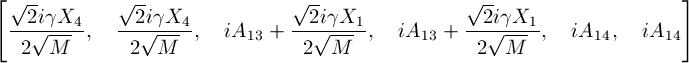

In [9]:
Eq25s = [
    com(Phi1,Phi2), com(Phi3, Phi4),
    com(Phi1,Phi3), com(Phi4, Phi2),
    com(Phi1,Phi4), com(Phi2, Phi3)
]

ea(ansatz, Eq25s)

Which is Eq. (3.7).

We might also want to check that the decomposition in Eq. (3.4) satisfies Eq. (3.5) using Eq. (3.1). (note that this step depends on that the alternative solution to [SymPy PR#11598](https://github.com/sympy/sympy/pull/11598), found in that discussion, has not been merged)

In [10]:
from sympy.physics.quantum import TensorProduct as tp
from sympy.physics.quantum import tensor_product_simp as tps

D, X = symbols('D, X', commutative=False, hermitian=True)

algebra = [(D*X,X*D+I)] # Eq. (3.1)

deco = []

deco.append((D1, tp(D,1,1,1)))
deco.append((D2, tp(1,D,1,1)))
deco.append((D3, tp(1,1,D,1)))
deco.append((D4, tp(1,1,1,D)))

deco.append((X1, tp(X,1,1,1)))
deco.append((X2, tp(1,X,1,1)))
deco.append((X3, tp(1,1,X,1)))
deco.append((X4, tp(1,1,1,X)))

[
    tps(
        (
            (e[0])-(e[1])
        ).subs(deco)
    ).subs(algebra).expand(tensorproduct=True).subs(tp(1,1,1,1), 1) for e in com_rel
]

Which the above shows that it does.